# **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Assignment 3: n-gram Language Models, Word Sense disambiguation(LSA using SVD), LSTM**

### **Total points: 100**


# Q1. Latent Semantic Analysis (35 Points) 


 - A. Singular Value Decomposition (SVD) based distributed representation of text and documents. You can use python libraries for matrix decomposition (scipy). To demonstrate your work, use the example dataset (Table 2) of "R. A. Harshman (1990). Indexing by latent semantic analysis. Journal of the American society for information science". (10 Points)

 - B. Visualize (2-D) the documents and terms using library of your choice. (10 Points)

 - C. Implement a function that converts a query string to distributed representation and retrieves relevent documents. Visualize the the results as shown in Fig 1 of the paper. (10 Points)

## <CENTER>Task-1 (10 Points)

In [ ]:
import numpy as np
import math
import pandas as pd
import re
import nltk
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import itertools
import scipy

### Input data

In [ ]:
#Dataset
c1 = 'Human machine interface for Lab ABC computer applications'
c2 = 'A survey of user opinion of computer system response time'
c3 = 'The EPS user interface management system'
c4 = 'System and human system engineering testing of EPS'
c5 = 'Relation of user-perceived response time to error measurement'
m1 = 'The generation of random, binary, unordered trees'
m2 = 'The intersection graph of paths in trees'
m3 = 'Graph minors IV: Widths of trees and well-quasi-ordering'
m4 = 'Graph minors: A survey'
documents = [c1, c2, c3, c4, c5, m1, m2, m3, m4]

### Perform preprocessing of documents

In the below cell remove punctuations and keep only words which belong to nltk corpus

In [ ]:
# TASK CELL
def preprocess(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        preprocessed_message_list: a list of words containing the processed message. 

    '''
    preprocessed_message_list = re.sub('[^A-Za-z0-9]+', ' ', message)
    preprocessed_message_list = [word.lower() for word in preprocessed_message_list.split(' ')]
    
    return preprocessed_message_list

### Verify preprocessed data

In [ ]:
for sent in documents:
    print(preprocess(sent))

['human', 'machine', 'interface', 'for', 'lab', 'abc', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'eps', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'eps']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'iv', 'widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']


##### Expected Output
```CPP
['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']
```

### Assign names to document names
In the below cell create a list of document names. It will be later used to visualize documents

In [ ]:
def createDocName(documents):
    '''
    Input:
        documents: list of documents.
    Output:
        doc_names: a list of document names. 

    '''

    docNameLst = ['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4'];
    return docNameLst;

In [ ]:
docName = createDocName(documents)
print(docName)

['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']


##### Expected Output
``` CPP
['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
```

### Words to Index mapping
Retrieve words from documents and create map of word and associate index to it

In [ ]:
def build_word_to_ix(documents, stopwords=None):
    '''
    Input:
        documents: list of documents
        stopwords: list of stopwords
    Output:
        doc_names: map of words and assoicated index. 

    '''
    doc_list = [];
    word_list = [];
    word_ix = {};
    
    for message in documents:
        message = [word for word in message.split(' ') if word.lower() not in stopwords];
        message = preprocess(' '.join(message));
        doc_list.append(message);
        
    word_list = list(itertools.chain.from_iterable(doc_list));
    
    i = 0
    
    for word in word_list:
        if word_list.count(word.lower()) > 1 and word not in word_ix:
            word_ix[word] = i;
            i = i + 1;
        
    return word_ix;

In [ ]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english');
word_to_ix = build_word_to_ix(documents, stopwords)
print(word_to_ix)

{'human': 0, 'interface': 1, 'computer': 2, 'survey': 3, 'user': 4, 'system': 5, 'response': 6, 'time': 7, 'eps': 8, 'trees': 9, 'graph': 10, 'minors': 11}


##### Expected Output
```CPP
{'human': 0, 'interface': 1, 'computer': 2, 'user': 3, 'survey': 4, 'system': 5, 'time': 6, 'response': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}
```

### Document-Terms count matrix

In [ ]:
def build_td_matrix(documents, word_to_ix):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
    Output:
        td_matrix: matrix of count of words in documents, each row 
            represent a word and each column represent a document

    '''
    td_matrix = [];
    doc_list = [];
    
    for message in documents:
        message = [word for word in message.split(' ') if word.lower() not in stopwords];
        message = preprocess(' '.join(message));
        doc_list.append(message);
    
    for word in word_to_ix:
        word_tmp = [];
        for document in doc_list:
            word_tmp.append(document.count(word.lower()));
        td_matrix.append(word_tmp);
        
    return np.array(td_matrix);

In [ ]:
X = build_td_matrix(documents, word_to_ix)
print(X)

[[1 0 0 1 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1]
 [0 1 1 0 1 0 0 0 0]
 [0 1 1 2 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]
 [0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 1]]


##### Expected Output
```CPP
[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 ```

### Singular Value Decomposition
Perform singular value decomposition of count matrix into term singular vector matrix, singular value matrix and document singular vector matrix
- To perform the singular value decompostion please check tutorial:
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [ ]:
def svd(documents, word_to_ix, rank):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
        rank: number of colums/rows to retain in decomposed matrix
    Output:
        Uk: term singular vector matrix
        Sk: singular value matrix
        Vk_t: transpose of document singular vector matrix
    '''
    X = build_td_matrix(documents, word_to_ix);
    Uk, Sk, Vk_t = scipy.linalg.svd(X, full_matrices=False)
    return Uk[:,:rank], np.diag(Sk[:rank]), Vk_t.transpose()[:,:rank]

In [ ]:
Uk, Sk, Vk_t = svd(documents, word_to_ix, 2)
print(Uk)
print(Sk)
print(Vk_t)

[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.20591786  0.27364743]
 [-0.40359886  0.05707026]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]


##### Expected Output
```CPP 
[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.40359886  0.05707026]
 [-0.20591786  0.27364743]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]
 ```

## <CENTER>Task-2 (10 Points)

### Visualize documents in 2D space

Coordinates of documents 
  [[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]


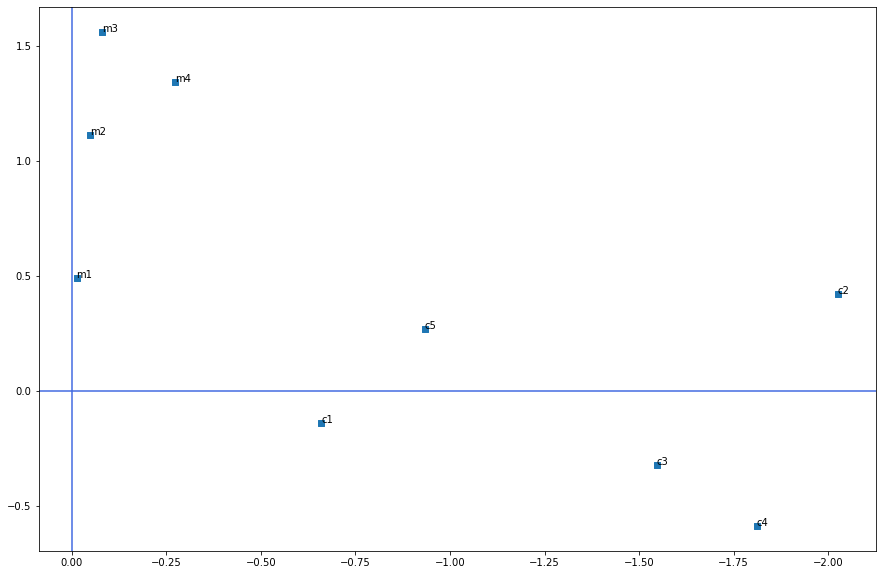

In [ ]:
#Visualize documents and print coordinates
doc_coord = np.dot(Vk_t, Sk);
print("Coordinates of documents \n ", doc_coord);

# get a figure handle
fig,ax = plt.subplots(figsize=(15,10))
plt.scatter(doc_coord[:, :1], doc_coord[:, 1:], marker = ",")
plt.gca().invert_xaxis()

plt.axhline(0, color='royalblue')
plt.axvline(0, color='royalblue')

for i, txt in enumerate(docName):
    ax.annotate(txt, (doc_coord[:, :1][i], doc_coord[:, 1:][i]))

plt.show()

##### Expected
```CPP
[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]
```
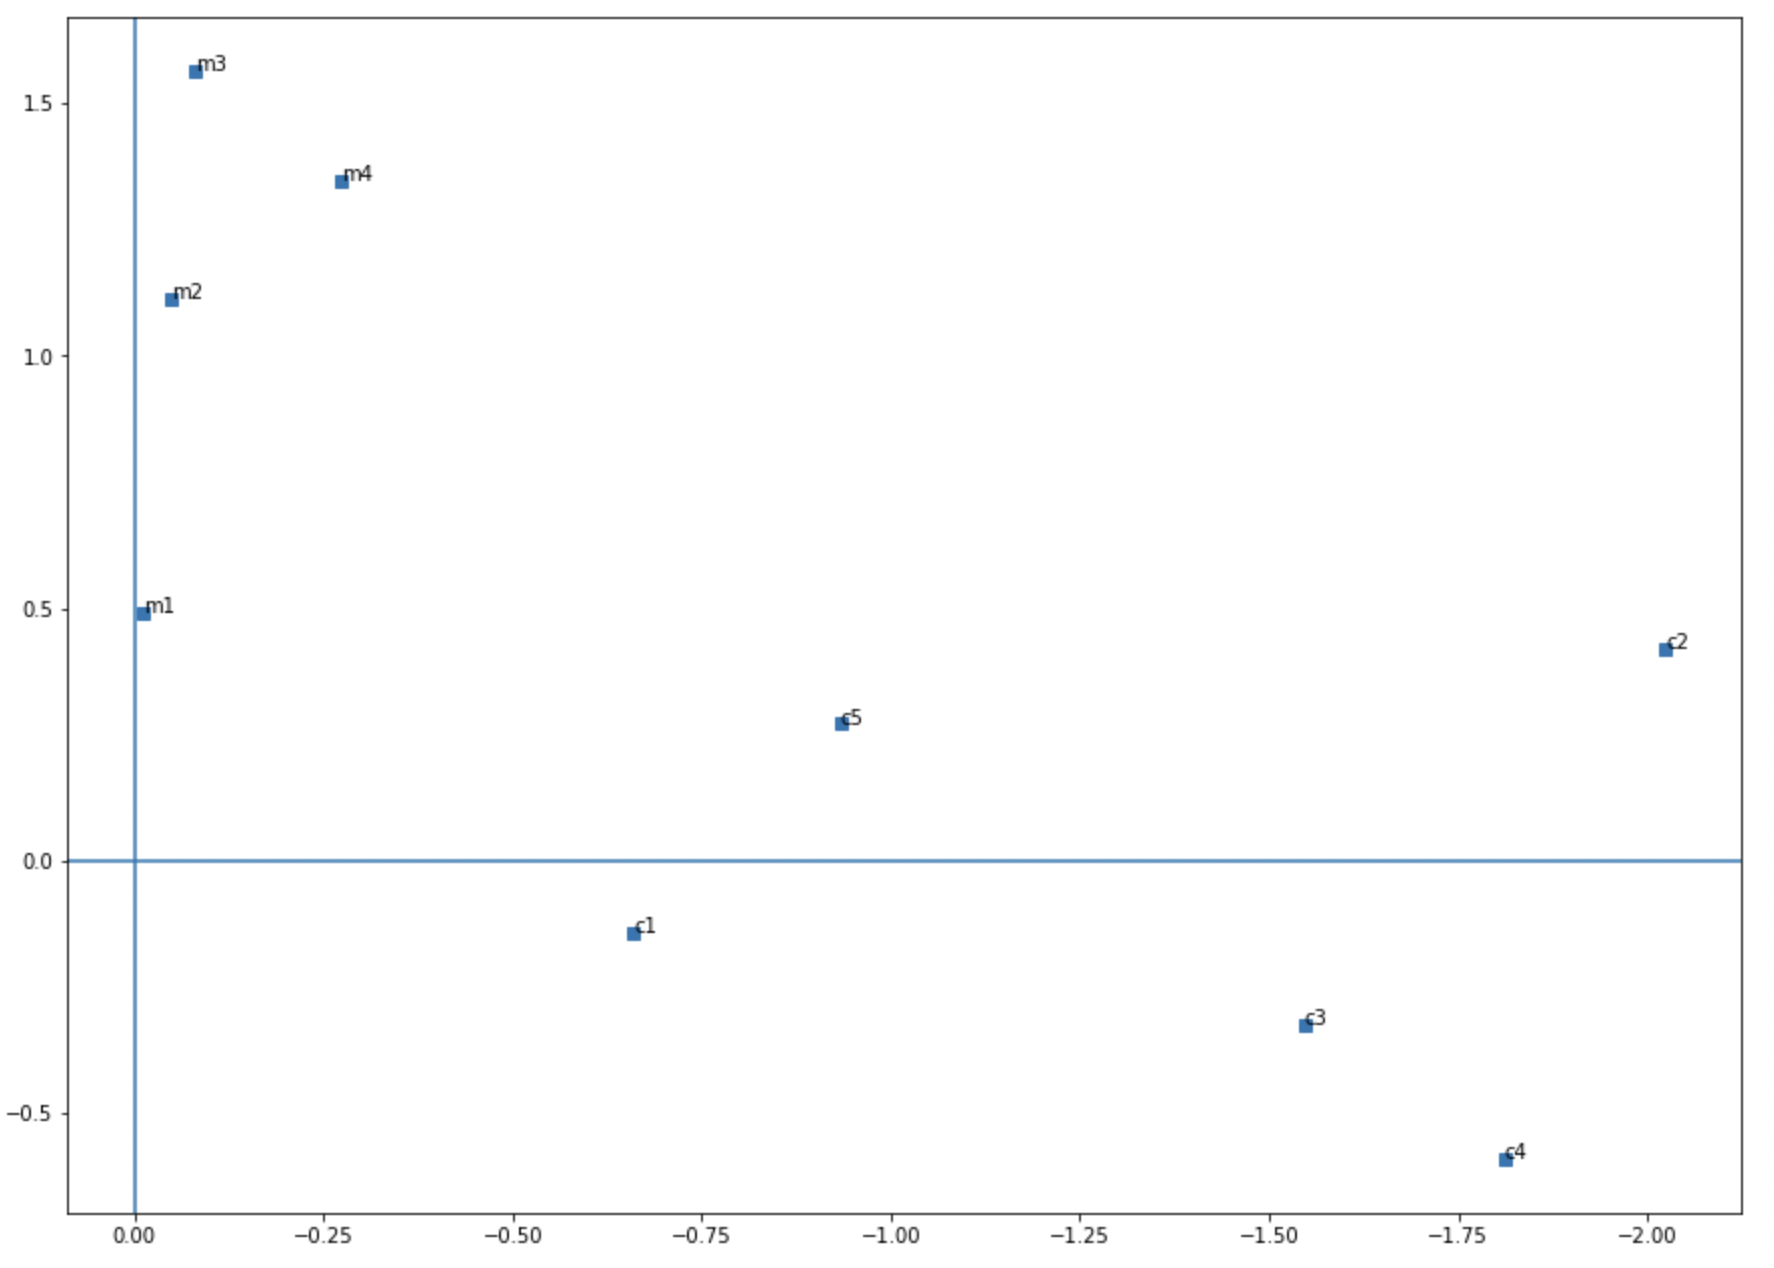

### Visualize terms in 2D space

Coordinates of words 
  [[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-0.68794764  0.69552995]
 [-1.34837689  0.14505553]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]


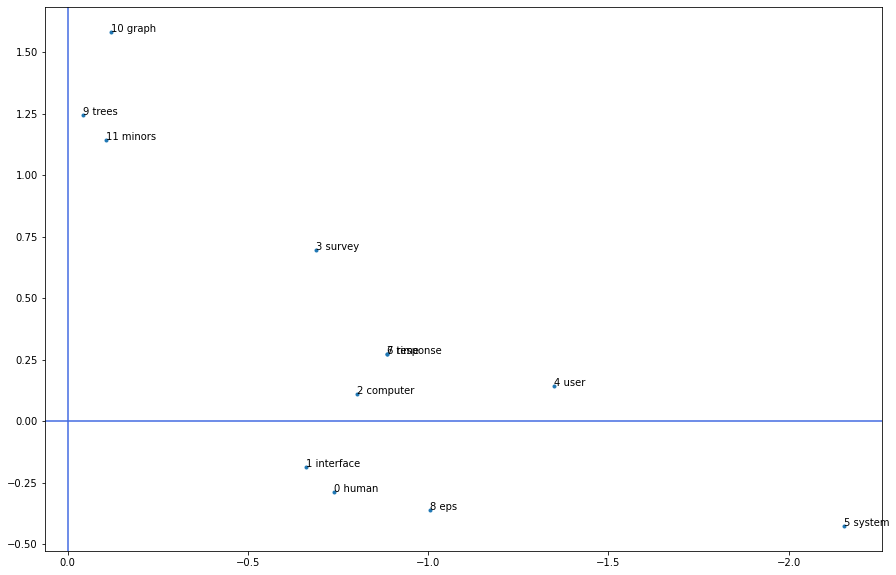

In [ ]:
#Visualize terms and print coordinates
word_coord = np.dot(Uk, Sk);
print("Coordinates of words \n ", word_coord);

# get a figure handle
fig,ax = plt.subplots(figsize=(15,10))
plt.scatter(word_coord[:, :1], word_coord[:, 1:], marker = ".")
plt.gca().invert_xaxis()

plt.axhline(0, color='royalblue')
plt.axvline(0, color='royalblue')

for i, txt in enumerate(word_to_ix):
    ax.annotate(str(i) + ' ' + txt, (word_coord[:, :1][i], word_coord[:, 1:][i]))

plt.show()

##### Expected
```CPP
[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-1.34837689  0.14505553]
 [-0.68794764  0.69552995]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]
```
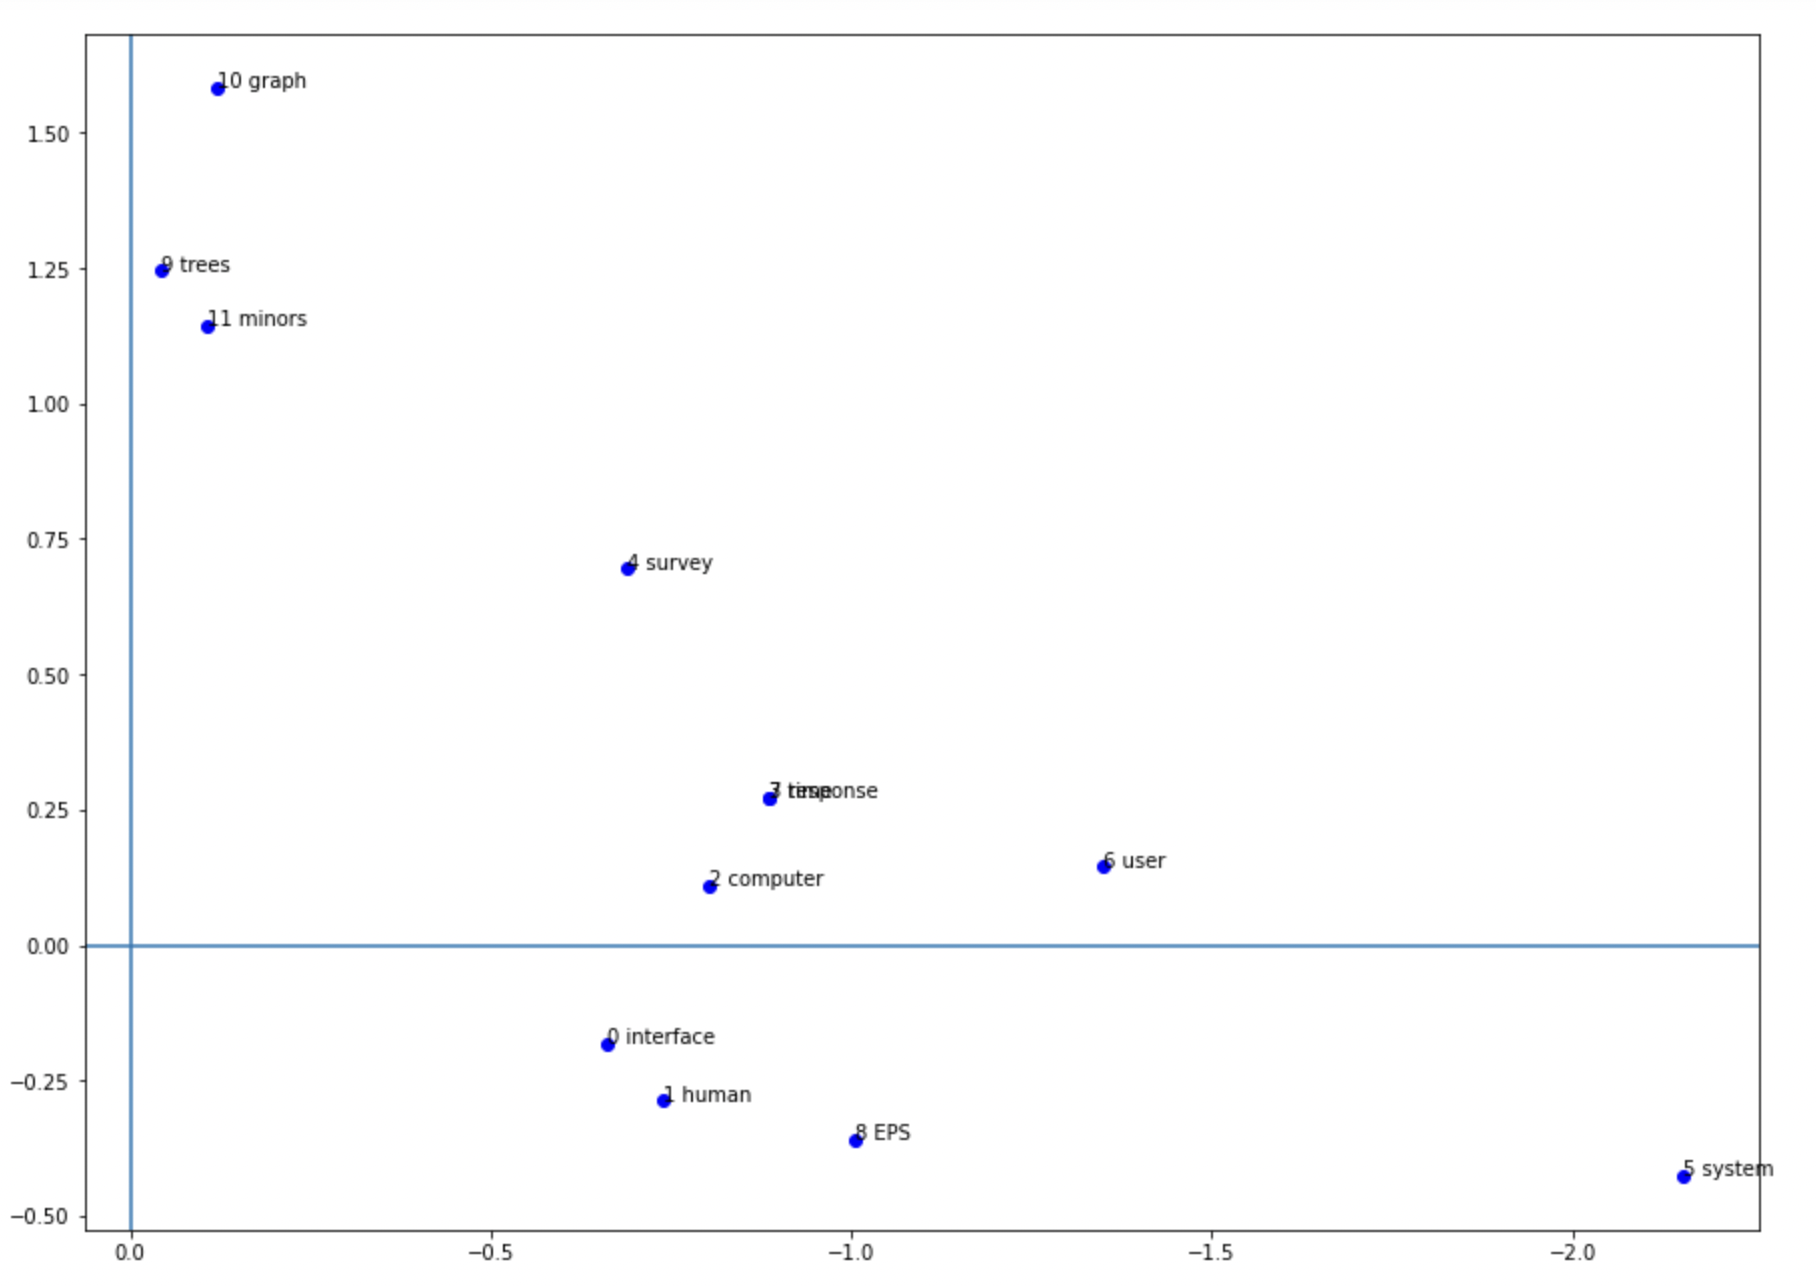

## <CENTER>Task-3 (10 Points)

### Find matching documents for given document

In [ ]:
# Hint create query vector for input document. Calculate its cosine distance from other documents


def query(s, Uk, Sk, Vk_t, word_to_ix, documents, min_score=0.9):
    '''
    Input:
        s:query document.
        Uk:Term matrix
        Sk:singular value matrix
        Vk_t:Document matrix
        word_to_ix: {word, index} map
        documents:list of document
        min_score:min score beyond which documents are considerd matching
    Output:
        q_hat: coordinates of query vector
        matches: list of tuples containing matching document and its score
    '''
    matches = [s];
    X_s = np.array(list(itertools.chain.from_iterable(build_td_matrix(matches, word_to_ix))));
    q_hat = np.dot(X_s, Uk);

    cosine_tmp = [];
    for i in range(1,len(documents)+1):
        d = np.dot(q_hat, np.dot(Vk_t[i-1:i, :], Sk).transpose())/(np.linalg.norm(q_hat)*np.linalg.norm(np.dot(Vk_t[i-1:i, :], Sk)));
        if d >= min_score:
            matches.append((documents[i-1], d[0]))
        
    return q_hat, matches

In [ ]:
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[-0.461821   -0.07002767]
['human computer interaction', ('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('A survey of user opinion of computer system response time', 0.9374863669686577), ('The EPS user interface management system', 0.9984452813340272), ('System and human system engineering testing of EPS', 0.9865886405556593), ('Relation of user-perceived response time to error measurement', 0.9075594362644304)]


##### Expected
```CPP
[-0.461821   -0.07002767]
[('The EPS user interface management system', 0.9984452813340272), ('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('System and human system engineering testing of EPS', 0.9865886405556598), ('A survey of user opinion of computer system response time', 0.9374863669686595), ('Relation of user-perceived response time to error measurement', 0.9075594362644345)]
```

### Visual representation of query/document

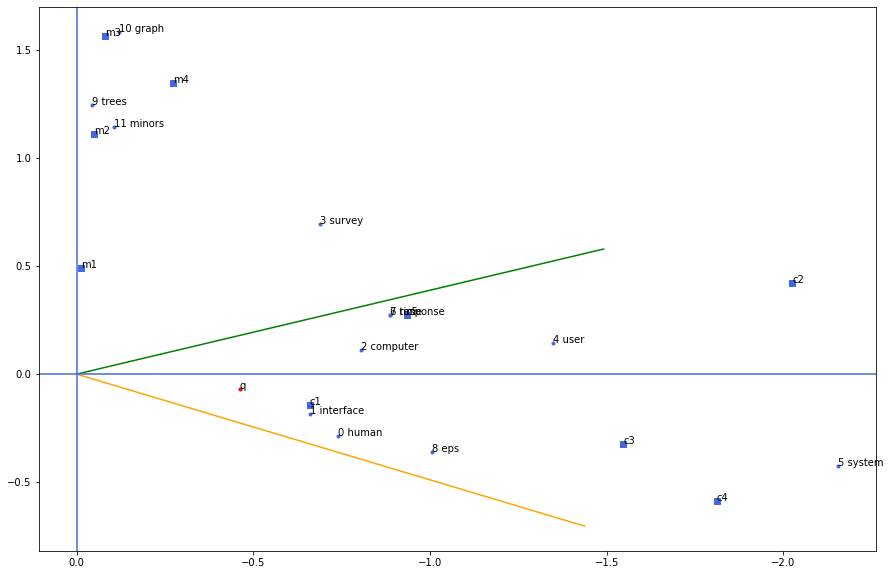

In [ ]:
# Plot terms, documents and query documents along with lines representing its cosine angle 

doc_coord = np.dot(Vk_t, Sk);
word_coord = np.dot(Uk, Sk);

# get a figure handle
fig,ax = plt.subplots(figsize=(15,10))

plt.scatter(doc_coord[:, :1], doc_coord[:, 1:], marker = ",", c = 'royalblue')
plt.scatter(word_coord[:, :1], word_coord[:, 1:], marker = ".", c = 'royalblue')
plt.scatter(q_hat[:1], q_hat[1:], marker = ".", c = 'red')

v1 = [q_hat[0], (0.92 * (np.linalg.norm(q_hat) ** 2) -  q_hat[0] ** 2)/q_hat[1]]
v2 = [q_hat[0], (1.05 * (np.linalg.norm(q_hat) ** 2) -  q_hat[0] ** 2)/q_hat[1]]
v1_l = 1.6/np.linalg.norm(v1) 
v2_l = 1.6/np.linalg.norm(v2) 
plt.plot([0, v1_l * v1[0]], [0, v1_l * v1[1]],c = 'green')
plt.plot([0, v2_l * v2[0]], [0, v2_l * v2[1]],c = 'orange')


plt.gca().invert_xaxis()

plt.axhline(0, color='royalblue')
plt.axvline(0, color='royalblue')

for i, txt in enumerate(docName):
    ax.annotate(txt, (doc_coord[:, :1][i], doc_coord[:, 1:][i]))

for i, txt in enumerate(word_to_ix):
    ax.annotate(str(i) + ' ' + txt, (word_coord[:, :1][i], word_coord[:, 1:][i]))
    
ax.annotate('q', (q_hat[:1][0], q_hat[1:][0]))

plt.show()

##### Expected

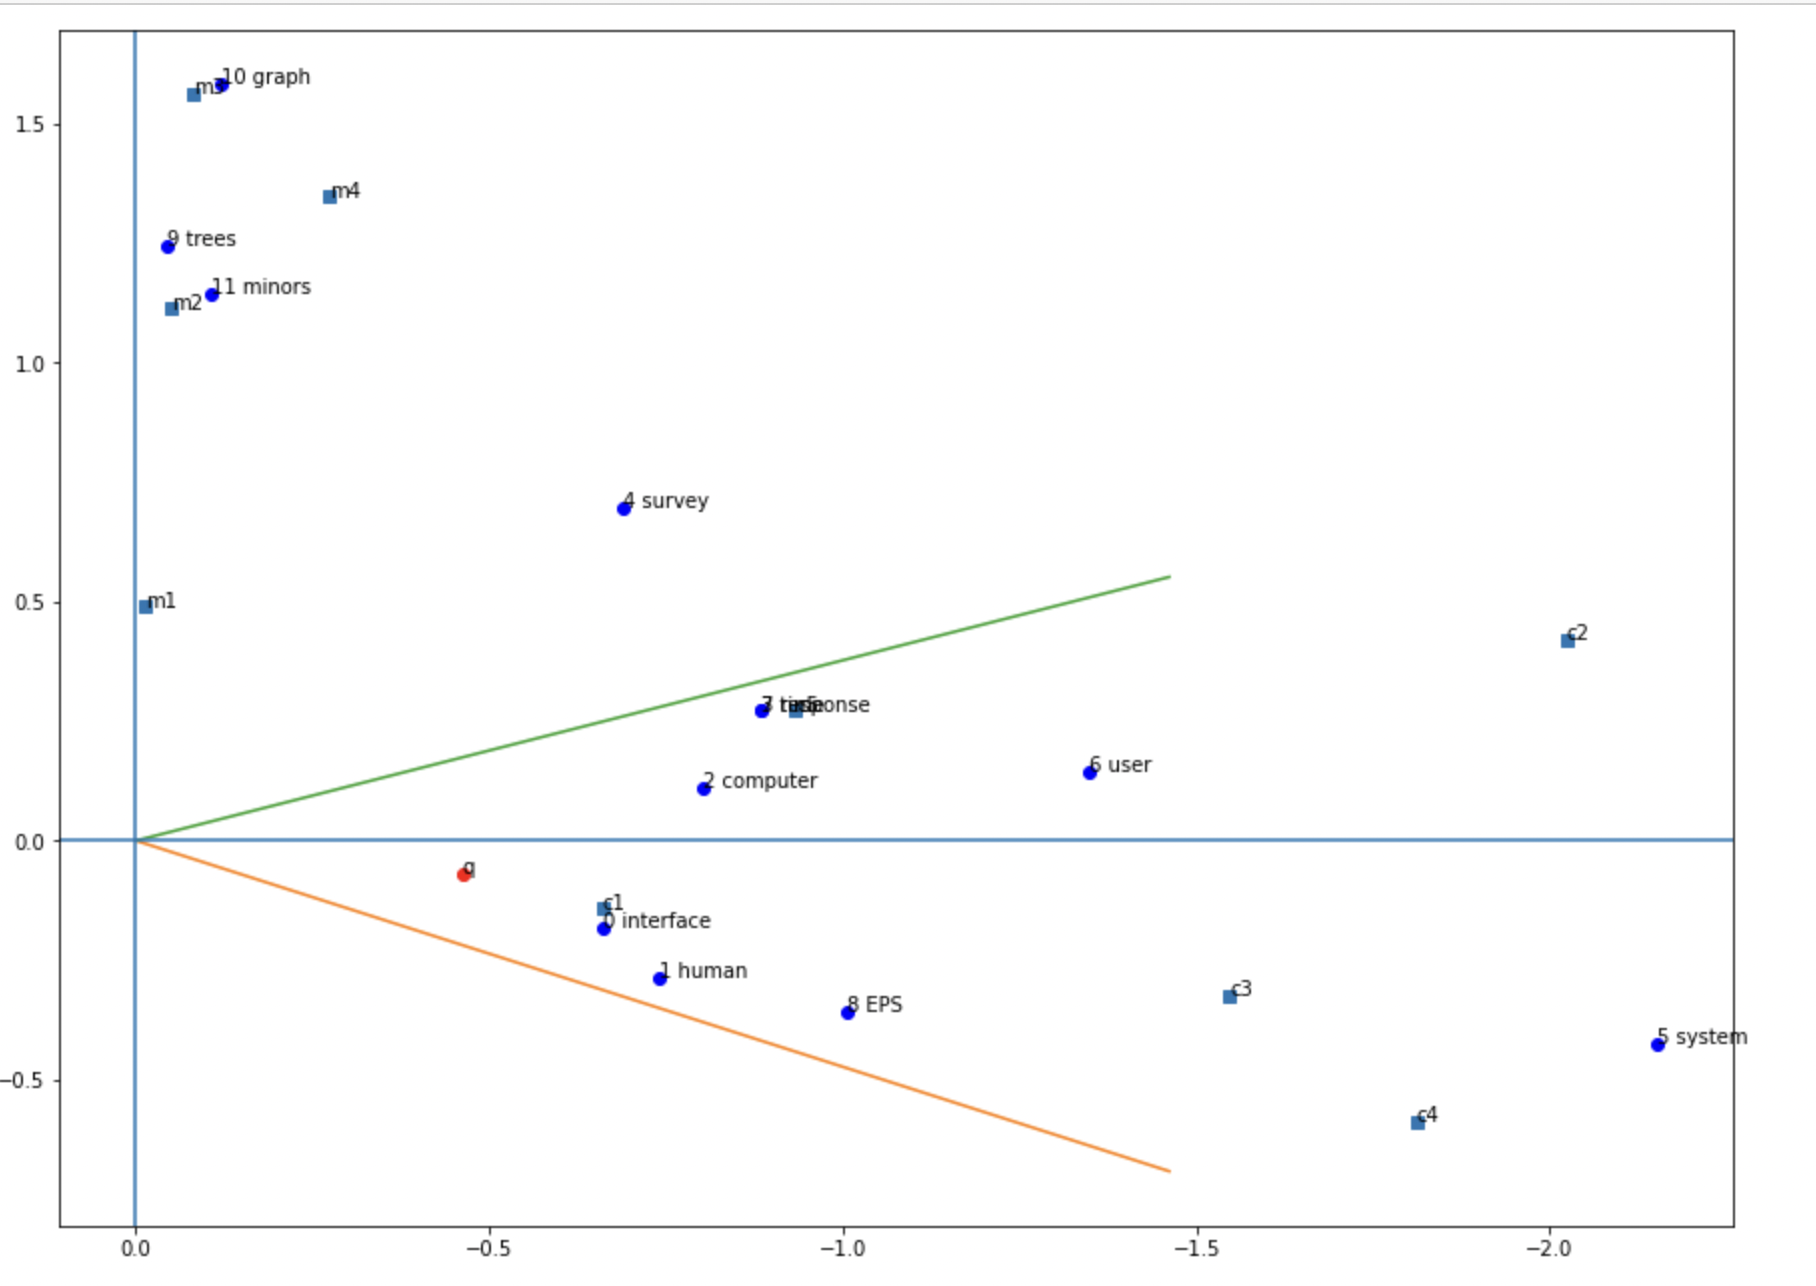


## **Theory questions: (5 points)**
- A) Give short description of Left-eigen vectors, right-eigen vectors and eigen-values matrix retured by Singular Value Decompostion of document-terms count matrix.
- B) Visually represent the document "Graph and tree generation" in 2D space along with words and documents as given in previous question.

**Solution**
i) The SVD decomposition given in this case was provided with the input matrix containing document term frequency details. The left, right eigen vectors and eigen values returned by svd were in this case special matrices that show the relationship between word-word, document to document and word to document each. The left eigen vectors were word to word relations in the spatial configuration whereas the right eigen vectors show cased the relationship of document to document in the spatial configuration.

ii) Here s is 'Graph and tree generation'

[-0.03613585  0.62278523]


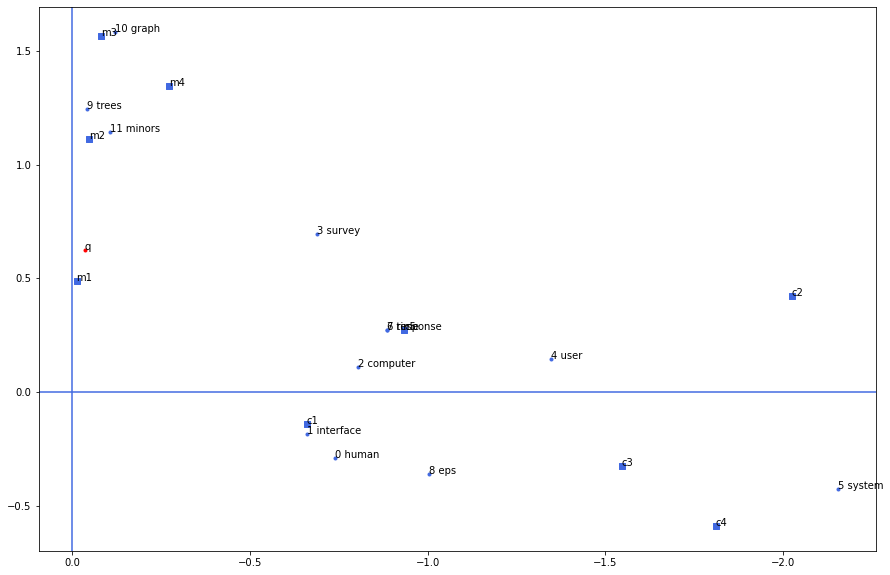

In [ ]:
s = 'Graph and tree generation'
q_hat, matches = query(s, Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)

# Plot terms, documents and query documents along with lines representing its cosine angle 

doc_coord = np.dot(Vk_t, Sk);
word_coord = np.dot(Uk, Sk);

# get a figure handle
fig,ax = plt.subplots(figsize=(15,10))

plt.scatter(doc_coord[:, :1], doc_coord[:, 1:], marker = ",", c = 'royalblue')
plt.scatter(word_coord[:, :1], word_coord[:, 1:], marker = ".", c = 'royalblue')
plt.scatter(q_hat[:1], q_hat[1:], marker = ".", c = 'red')

plt.gca().invert_xaxis()

plt.axhline(0, color='royalblue')
plt.axvline(0, color='royalblue')

for i, txt in enumerate(docName):
    ax.annotate(txt, (doc_coord[:, :1][i], doc_coord[:, 1:][i]))

for i, txt in enumerate(word_to_ix):
    ax.annotate(str(i) + ' ' + txt, (word_coord[:, :1][i], word_coord[:, 1:][i]))
    
ax.annotate('q', (q_hat[:1][0], q_hat[1:][0]))

plt.show()

# Q2. n-Gram Language Models

Your task is to train n-gram language models. [Ref SLP Chapter 3]

- Task 1: You will train unigram, bigram, and trigram models on given training files. Then you will score on given test files for unigram, bigram, and trigram. you will generate sentences from the trained model and compute perplexity.
- Task 2: You will create training data for n > 3. and Repeat the above task from training model.
<h6>Part-A = (55 Points) </h6>

In [ ]:
'''
Your imports go here
You are encouraged to implement your own functions and not use from library.
'''
import sys
from collections import Counter
import numpy as np

In [ ]:
# constants to define pseudo-word tokens
# access via UNK, for instance
# for this assignemnt we will follow <s> tag for beginning of sentence and
# </s> for end of senetence as suggested in SLP Book. Check sample training files for reference.
UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"

We need to initialise global variables for model

In [ ]:
"""Initializes Parameters:
  n_gram (int): the n-gram order.
  is_laplace_smoothing (bool): whether or not to use Laplace smoothing
  threshold: words with frequency  below threshold will be converted to token
"""
# Initializing different object attributes
n_gram = None
is_laplace_smoothing = True
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = None
threshold = 1


### Implement training function (10 points)

In [ ]:
def make_ngrams(tokens: list, n: int) -> list:
    """Creates n-grams for the given token sequence.
    Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create

    Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
    """
    n_grams = []
    ## Your code here 
    for i in range(len(tokens) - n + 1):
        n_grams.append(tokens[i:i+n])

    return n_grams

In [ ]:
def fix_sent_begin_end(content):
    i = 1;
    while i <= len(content) - 1: 
        if content[i] == SENT_BEGIN and content[i+1] != SENT_BEGIN:
                content.insert(i-1, SENT_BEGIN);
                i = i + 2;
        elif content[i] != SENT_END and content[i+1] == SENT_END:
                content.insert(i+1, SENT_END);
                i = i + 2;
        else:
            i = i + 1;
    return content;

In [ ]:
def train(training_file_path, n):
    """Trains the language model on the given data. Input file that
    has tokens that are white-space separated, has one sentence per line, and
    that the sentences begin with <s> and end with </s>
    Parameters:
      training_file_path (str): the location of the training data to read

    Returns:
    N Gram Counts, Vocab, N Minus 1 Gram Counts
    """
    with open(training_file_path, 'r') as fh:
        content = fh.read().split() # Read and split data to get list of words
    content = fix_sent_begin_end(content);
        
    # Get the count of each word
    word_dict = {};
    for word in content:
        if word not in word_dict:
            word_dict[word] = content.count(word);
            
    # Replace the words with <UNK> if count is < threshold(=1)
    word_del_list = {};
    for word in word_dict:
        if word_dict[word] <= 1:
            word_del_list[word] = word_dict[word];
            
    for k in word_del_list:
        word_dict[UNK] = word_del_list[k]
        word_dict.pop(k, None)
                
    # make use of make_n_grams function
    n_grams = make_ngrams(content, n);
    n_1_grams = make_ngrams(content, n-1);
    
    # Get the training data vocabulary
    vocab = list(filter((SENT_BEGIN).__ne__, content))
    vocab = list(filter((SENT_END).__ne__, vocab))
    vocab = list(set(vocab))

    
    n_gram_counts = {};
    n_minus_1_gram_counts = {};
    
    # For n>1 grams compute n-1 gram counts to compute probability
    for n_gram in n_grams:
        if tuple(n_gram) not in n_gram_counts:
            n_gram_counts[tuple(n_gram)] = n_grams.count(n_gram);
        
    for n_1_gram in n_1_grams:
        if tuple(n_1_gram) not in n_minus_1_gram_counts:
            n_minus_1_gram_counts[tuple(n_1_gram)] = n_1_grams.count(n_1_gram);

    return n_gram_counts, vocab, n_minus_1_gram_counts

In [ ]:
path_to_training_file = 'C:/Users/Shivapriya B/Desktop/NEU Work/Classwork/Semester 4/Natural Language Processing/Week 6/data/train_data/berp-training-tri.txt'
n = 4;
n_gram_counts, vocab, n_minus_1_gram_counts = train(path_to_training_file, n)
print(n_gram_counts)
print(vocab)

{('<s>', '<s>', '<s>', "let's"): 196, ('<s>', '<s>', "let's", 'start'): 163, ('<s>', "let's", 'start', 'over'): 131, ("let's", 'start', 'over', '</s>'): 124, ('start', 'over', '</s>', '</s>'): 366, ('over', '</s>', '</s>', '</s>'): 367, ('</s>', '</s>', '</s>', '<s>'): 6755, ('</s>', '</s>', '<s>', '<s>'): 6755, ('</s>', '<s>', '<s>', '<s>'): 6755, ('<s>', '<s>', '<s>', 'my'): 6, ('<s>', '<s>', 'my', 'mother'): 1, ('<s>', 'my', 'mother', 'is'): 1, ('my', 'mother', 'is', 'coming'): 1, ('mother', 'is', 'coming', 'to'): 1, ('is', 'coming', 'to', 'visit'): 1, ('coming', 'to', 'visit', 'and'): 1, ('to', 'visit', 'and', "i'd"): 1, ('visit', 'and', "i'd", 'like'): 1, ('and', "i'd", 'like', 'to'): 4, ("i'd", 'like', 'to', 'take'): 4, ('like', 'to', 'take', 'her'): 1, ('to', 'take', 'her', 'to'): 1, ('take', 'her', 'to', 'dinner'): 1, ('her', 'to', 'dinner', '</s>'): 1, ('to', 'dinner', '</s>', '</s>'): 7, ('dinner', '</s>', '</s>', '</s>'): 224, ('<s>', '<s>', '<s>', 'new'): 1, ('<s>', '<s>', 

Output your Trained Data Parameters:

In [ ]:
# Expected Output
n_gram_counts, vocab, n_minus_1_gram_counts = train("path_to_training_file")
print(n_gram_counts)
print(vocab)

{('<s>', '<s>', '<s>', "let's"): 196, ('<s>', '<s>', "let's", 'start'): 163, ('<s>', "let's", 'start', 'over'): 131, ("let's", 'start', 'over', '</s>'): 124, ('start', 'over', '</s>', '</s>'): 366, ('over', '</s>', '</s>', '</s>'): 367, ('</s>', '</s>', '</s>', '<s>'): 6755, ('</s>', '</s>', '<s>', '<s>'): 6755, ('</s>', '<s>', '<s>', '<s>'): 6755, ('<s>', '<s>', '<s>', 'my'): 6, ('<s>', '<s>', 'my', 'mother'): 1, ('<s>', 'my', 'mother', 'is'): 1, ('my', 'mother', 'is', 'coming'): 1, ('mother', 'is', 'coming', 'to'): 1, ('is', 'coming', 'to', 'visit'): 1, ('coming', 'to', 'visit', 'and'): 1, ('to', 'visit', 'and', "i'd"): 1, ('visit', 'and', "i'd", 'like'): 1, ('and', "i'd", 'like', 'to'): 4, ("i'd", 'like', 'to', 'take'): 4, ('like', 'to', 'take', '<UNK>'): 1, ('to', 'take', '<UNK>', 'to'): 1, ('take', '<UNK>', 'to', 'dinner'): 1, ('<UNK>', 'to', 'dinner', '</s>'): 1, ('to', 'dinner', '</s>', '</s>'): 7, ('dinner', '</s>', '</s>', '</s>'): 224, ('<s>', '<s>', '<s>', 'new'): 1, ('<s>',

### Scoring function (points 5):
Implement Score function that will take input sentence and output probability of given string representing a single sentence.

In [ ]:
def score(sentence):
    """Calculates the probability score for a given string representing a single sentence.
    Parameters:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
      
    Returns:
      float: the probability value of the given string for this model
    """
    # Split the input sentence and replace out of vocabulary tokens with <UNK>     
    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability
    
    words = [x for x in sentence];
    probablity = 1
    for i in range(len(words)):
        if words[i] not in vocab:
            words[i] = UNK;
    
    if n == 1:
        for word in words:
            num = content.count(word);
            probablity = probablity * (num/len(vocab));

    elif n > 1:
        probablity = 1
        
        n_gram = sentence[:n-1];
        i = n-1;
        while i < len(words):
            n_gram_tmp = [x for x in n_gram];
            n_gram_tmp.append(words[i]);

            num = n_gram_counts[tuple(n_gram_tmp)];
            den = n_minus_1_gram_counts[tuple(n_gram)];
            probablity = probablity * (num/den);
            n_gram = n_gram_tmp[1:n]
            i = i + 1;
            print
        
    return probablity

In [ ]:
path_to_test_file = 'C:/Users/Shivapriya B/Desktop/NEU Work/Classwork/Semester 4/Natural Language Processing/Week 6/data/test_data/hw2-test-tri.txt'
with open(path_to_test_file, 'r') as fh:
    test_content = fh.read().split("\n")
num_sentences_1 = len(test_content)
ten_sentences_1 = test_content[:10]
print("# of test sentences: ", num_sentences_1)
probablities = []

# of test sentences:  102


In [ ]:
# print probabilities/score of sentences in test content
for sentence in test_content:
    probablities.append(score(sentence))
probablities = np.array(probablities)
mean = np.mean(probablities)
std_dev = np.std(probablities)

### Sentence generation (10 points)
Generate sentence from the above trained model
- To generate next word from a set of probable n-grams and their probabilities check below tutorial:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [ ]:
def generate_sentence(n):
    """Generates a single sentence from a trained language model using the Shannon technique.
      
    Returns:
      str: the generated sentence
    """
    # Start with <s> and randomly generate words until we encounter sentence end
    sentence = '<s> ';
    final_sent = [];

    # Append sentence begin markers for n>2
    if n > 2:
        final_sent.append(SENT_BEGIN);
        final_sent.append(SENT_BEGIN);
        
    prev_word = SENT_BEGIN;
    
    # Keep track of previous word for stop condition
    if n > 1:
#         n_gram_counts, vocab, n_minus_1_gram_counts = train("path_to_training_file");
        
        n_gram = [SENT_BEGIN] * n;
        while prev_word != "</s>":
            num_prob = {};
            prob = n_minus_1_gram_counts[tuple(n_gram[1:n])];
            prob_Lst = {};
        # Construct the (n-1) gram so far
        # Get the counts of all available choices based on n-1 gram
            for word in vocab:
                n_gram_tmp = [x for x in n_gram];
                n_gram_tmp.append(word);
                n_gram_tmp = n_gram_tmp[(-1*n):]

                if tuple(n_gram_tmp) in n_gram_counts:
                    count = n_gram_counts[tuple(n_gram_tmp)];
                else:
                    count = 0;
                num_prob[tuple(n_gram_tmp)] = count;
        # Convert the counts into probability for random.choice() function
            for key in num_prob:
                prob_Lst[key] = num_prob[key] / prob;
        # If <s> is generated, ignore and generate another word
            prev_word = SENT_BEGIN;
            while prev_word == SENT_BEGIN:
                prev_word = np.random.choice(vocab, 1, p=list(prob_Lst.values()))[0]
                
            n_gram.append(prev_word);
            n_gram = n_gram[(-1*n):];
            final_sent.append(prev_word);
                
    else:
      # In case of unigram model, n-1 gram is just the previous word and possible choice is whole vocabulary
        while prev_word != "</s>":
            num_prob = {};
            prob = len(content);
            prob_Lst = {};
            for word in vocab:
                num_prob[word] = content.count(word);
                
        # Convert the counts into probability for random.choice() function
            for key in num_prob:
                prob_Lst[key] = num_prob[key]/prob;
        # If <s> is generated, ignore and generate another word
            prev_word = SENT_BEGIN;
            while prev_word == SENT_BEGIN:
                prev_word = np.random.choice(vocab, 1, p=list(prob_Lst.values()))[0]

            n_gram.append(prev_word);
            n_gram = n_gram[(-1*n):];
            final_sent.append(prev_word);
            
    # Append sentence end markers for n>2
    final_sent.append(SENT_END);
    sentence = ' '.join(final_sent);

    return sentence

In [ ]:
def generate(m):
    """Generates n sentences from a trained language model using the Shannon technique.
    Parameters:
      n (int): the number of sentences to generate
      
    Returns:
      list: a list containing strings, one per generated sentence
    """
    # Generate sentences one by one and store
    sentences = [];
    for i in range(m):
        sentences.append(generate_sentence(n));
        
    return sentences

In [ ]:
vocab = list(filter((SENT_BEGIN).__ne__, content))
vocab = list(filter((SENT_END).__ne__, vocab))
vocab = list(set(vocab))
vocab.append(SENT_BEGIN)
vocab.append(SENT_END)
vocab.append(UNK)

In [ ]:
training_file_path = 'C:/Users/Shivapriya B/Desktop/NEU Work/Classwork/Semester 4/Natural Language Processing/Week 6/data/train_data/berp-training-tri.txt'
with open(training_file_path, 'r') as fh:
    content = fh.read().split() # Read and split data to get list of words
content = fix_sent_begin_end(content);

sentences = generate(50)
print("Sentences:")
for sentence in sentences:
    print(sentence)

Sentences:
<s> <s> i'd like some chinese food please </s> </s>
<s> <s> i will be going out for lunch for under ten dollars uh with a ten minute walk </s> </s>
<s> <s> start over </s> </s>
<s> <s> tell me about um cancun </s> </s>
<s> <s> i would like to have some french food </s> </s>
<s> <s> i'm speaking clear english now right so i say i've got a car so it shouldn't matter </s> </s>
<s> <s> look at shilpa </s> </s>
<s> <s> let's start over </s> </s>
<s> <s> i'd like some chinese food </s> </s>
<s> <s> start over </s> </s>
<s> <s> please give me a place where i can get a glass of water </s> </s>
<s> <s> i want to spend six dollars and walk twenty minutes or less than ten dollars </s> </s>
<s> <s> how far from icksee </s> </s>
<s> <s> do i need reservations for this restaurant </s> </s>
<s> <s> i said greek restaurant </s> </s>
<s> <s> i would like to eat breakfast </s> </s>
<s> <s> i would like to eat today in in about an hour from icsi </s> </s>
<s> <s> start over </s> </s>
<s> <s> t

### Evaluate model perplexity (5 points)
Measures the perplexity for the test sequence with your trained model. 
you may assume that this sequence may consist of many sentences "glued together"

The perplexity of the given sequence is the inverse probability of the test set, normalized by the number of words.


In [ ]:
# Since this sequence will cross many sentence boundaries, we need to include 
# the begin- and end-sentence markers <s> and </s> in the probability computation. 
# We also need to include the end-of-sentence marker </s> 
# but not the beginning-of-sentence marker <s>) in the total count of word tokens N

def perplexity(test_sequence):
    """.
    Parameters:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity of

    Returns:
      float: the perplexity of the given sequence
    """ 

    # Replace out of vocab words with <UNK>, already done in score function
    test_sequence = [token for token in test_sequence.split()]

    # Remove sentence begin markers from data for computing N
    test_sequence = list(filter((SENT_BEGIN).__ne__, test_sequence))
    # Get the probability for the sequence
    perplexity = score(test_sequence);

    return perplexity

In [ ]:
sentences_test = sentences[0:10];
for sentence in sentences_test:
    print ("Sentence ", sentence);
    print("Perplexity ", perplexity(sentence))

Sentence  <s> <s> i'd like some chinese food please </s> </s>
Perplexity  0.009230769230769232
Sentence  <s> <s> i will be going out for lunch for under ten dollars uh with a ten minute walk </s> </s>
Perplexity  0.000992063492063492
Sentence  <s> <s> start over </s> </s>
Perplexity  1.0
Sentence  <s> <s> tell me about um cancun </s> </s>
Perplexity  0.004032258064516129
Sentence  <s> <s> i would like to have some french food </s> </s>
Perplexity  0.001001556793692021
Sentence  <s> <s> i'm speaking clear english now right so i say i've got a car so it shouldn't matter </s> </s>
Perplexity  0.04444444444444444
Sentence  <s> <s> look at shilpa </s> </s>
Perplexity  1.0
Sentence  <s> <s> let's start over </s> </s>
Perplexity  0.9117647058823529
Sentence  <s> <s> i'd like some chinese food </s> </s>
Perplexity  0.10153846153846154
Sentence  <s> <s> start over </s> </s>
Perplexity  1.0


### **Explore and explain: (5 points)**
* Experiment n_gram model for n = [1,2,3..7] of your choice. Explain the best choice of n that generates more meaninful sentences.


In [ ]:
# i) Experimenting with a n-gram of choice
# n = 3 chosen for experiment
n = 3;
n_gram_counts, vocab, n_minus_1_gram_counts = train(path_to_training_file, n)

training_file_path = 'C:/Users/Shivapriya B/Desktop/NEU Work/Classwork/Semester 4/Natural Language Processing/Week 6/data/train_data/berp-training-tri.txt'
with open(training_file_path, 'r') as fh:
    content = fh.read().split() # Read and split data to get list of words
content = fix_sent_begin_end(content);

sentences = generate(50)
print("Sentences:")
for sentence in sentences:
    print(sentence)
    
sentences_test = sentences[0:10];
for sentence in sentences_test:
    print ("Sentence ", sentence);
    print("Perplexity ", perplexity(sentence))

Sentences:
<s> <s> lunch </s> </s>
<s> <s> italian </s> </s>
<s> <s> i don't care about the cambodiana's </s> </s>
<s> <s> start over </s> </s>
<s> <s> give me information about caffe nefeli </s> </s>
<s> <s> i'd like to eat during the day of the week um well friday and the restaurant should be at the stuffed inn </s> </s>
<s> <s> i want to walk a mile from icsi </s> </s>
<s> <s> ten miles </s> </s>
<s> <s> polish food </s> </s>
<s> <s> i would like chinese food </s> </s>
<s> <s> i'm looking for an inexpensive restaurant </s> </s>
<s> <s> i want to go no further away </s> </s>
<s> <s> i don't care </s> </s>
<s> <s> let's start over </s> </s>
<s> <s> any amount of money </s> </s>
<s> <s> are there mexican restaurants </s> </s>
<s> <s> i like thai food </s> </s>
<s> <s> more than two hundred minutes from icsi </s> </s>
<s> <s> i would like to eat a gyro </s> </s>
<s> <s> i'd like to eat hungarian </s> </s>
<s> <s> would you please tell me more about caffe nefeli open </s> </s>
<s> <s> i'

ii) In comparing the n=3 (experimented above) and n=4 (original), we see that n=3 model gives a more wider variety of sentences with less repetition in sentences found and more meaningful sentences in comparison to the sentences created by an n=4 language model

# Q3. Classification using LSTM - using Tensorflow (30 Points)
In this part, we will be building a bidirectional LSTM network to train and inference sentiment analysis on IMDB dataset.<br>

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time to tweak your hyperparameters.
- Without a GPU, You might have to wait longer to experiment.

### Library Imports

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

### Visualizing data distribution (1 Point)


In [ ]:
## Reading the data and removing columns that are not important. 
# dataset = pd.read_csv("C:/Users/Shivapriya B/Desktop/NEU Work/Classwork/Semester 4/Natural Language Processing/Week 6/movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
dataset = pd.read_csv("movie_reviews.csv", sep = ',')
# , encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [ ]:
#######################################################   
# print head of data frame with help of head function # 
#######################################################
dataset.head() 

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Petter Mattei's "Love in the Time of Money" is...  positive
4  Probably my all-time favorite movie, a story o...  positive

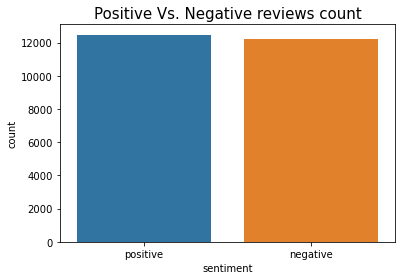

In [ ]:
 ####################################################### 
 # plot Positive Vs. Negative reviews count            # 
 #######################################################
sns.countplot(dataset.sentiment)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()

### Cleaning the Reviews (2 Points)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text_cleaned = '';
    tmp_text = text;
    #     Convert to lowercase
    tmp_text = ''.join([word.lower() for word in tmp_text])

    # Replace all stop words with space
    stop_words = stopwords.words('english');
    tmp_text = ' '.join([word for word in tmp_text.split() if word not in stop_words])

    #  Remove hyper links in text
    tmp_text = re.sub('http\S+', '', tmp_text)
    
    # Replace all punctuations with space
    tmp_text = ''.join([word for word in tmp_text if word not in set(string.punctuation)])

#     Stem each word in the review and append it to final review
    lem = nltk.WordNetLemmatizer();   
    tmp_text = ' '.join([lem.lemmatize(word) for word in tmp_text.split()]);

    return tmp_text

In [ ]:
# import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#############################################################################################  
# Clean all the reviews in the dataset using the clean_text function provided above         # 
############################################################################################# 
clean_reviews = [];
for review in dataset.review:
    clean_reviews.append(clean_text(review));

dataset['review'] = clean_reviews

In [36]:
#####################################################################
# print head of the "CLEANED" data frame with help of head function # 
#####################################################################
df = dataset;
df.head()

review sentiment
0  one reviewer mentioned watching 1 oz episode h...  positive
1  wonderful little production br br the filming ...  positive
2  thought wonderful way spend time hot summer we...  positive
3  petter matteis love time money visually stunni...  positive
4  probably alltime favorite movie story selfless...  positive

### Splitting the dataset and Encoding Labels (2 Points)

Spliting data: <br> 
80% for the training and the remaining 20% for validation.

Encoding Labels: <br>
Encode labels as negative and positive as 0 and 1 respectively


In [37]:
#################################################################################
# Split the data using the sklearn module                                       #
# 80% for the training and the remaining 20% for validation                     #
#################################################################################

x_train, x_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size=0.2);

In [38]:
x_train

1954     terrible boring zombie sequel marginally bette...
23170    corridor time movie watch looking sophisticate...
13706    im also sf buff among genre especially like fi...
13464    plot hole oj simpson alibi br br i noticed two...
12533    seen film many year ago made lasting impressio...
                               ...                        
3636     week week woman sweep men foot get real none w...
21824    jenny neumann from sexploitation flick mistres...
7842     the squire gothos kirk crew encounter powerful...
11486    big fan musical loved film fred astaire ginger...
11208    many socalled antiwarantigovt policy film arou...
Name: review, Length: 19759, dtype: object

In [40]:
#################################################################################
# Initialize label encoder from sklearn module                                  #
# fit on train labels and transform both train and validation labels            #
#################################################################################

encoder = LabelEncoder()
encoder.fit(y_train.unique());
y_train = encoder.transform(y_train)

In [66]:
x_train

1954     terrible boring zombie sequel marginally bette...
23170    corridor time movie watch looking sophisticate...
13706    im also sf buff among genre especially like fi...
13464    plot hole oj simpson alibi br br i noticed two...
12533    seen film many year ago made lasting impressio...
                               ...                        
3636     week week woman sweep men foot get real none w...
21824    jenny neumann from sexploitation flick mistres...
7842     the squire gothos kirk crew encounter powerful...
11486    big fan musical loved film fred astaire ginger...
11208    many socalled antiwarantigovt policy film arou...
Name: review, Length: 19759, dtype: object

In [41]:
y_train

array([0, 0, 0, ..., 1, 1, 0])

### Pre-Processing The Text (5 Points)
 

In [42]:
# You can use the modules given below
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

###############################################################################  
# Fit your tokenizer on the training reviews                                  #
###############################################################################

t = Tokenizer();
t.fit_on_texts(x_train) 

#################################################################################################
# The word_index dictionary assigns a unique index to each unique word present in the training  #
# reviews.                                                                                      #
#                                                                                               #
# Create the word_index dictionary using the tokenizer                                          #
# Find the vocabulary of your training reviews                                                  #
#################################################################################################

word_index = {}
word_index = t.word_index;    

vocabulary = list(word_index.keys())

#################################################################################################
# Convert the reviews in the dataset to their index form by using a function available          #
# with the tokenizer                                                                            #
# HINT : convert training and validation reviews into sequences                                 #
#################################################################################################

train_seq = t.texts_to_sequences(x_train)
test_seq = t.texts_to_sequences(x_test)

#################################################################################################
# Pad the the training and validation sequences so all of them have the same length             # 
# set maxlen = 200                                                                              #
#################################################################################################

x_train_pad = pad_sequences(train_seq, padding = 'post', truncating = 'post', maxlen = 200)
x_test_pad = pad_sequences(test_seq, padding = 'post', truncating = 'post', maxlen = 200)

# maxlen which is the maximum length of one review we will use for our training

print('Vocabulary : {}'.format(vocabulary))

Vocabulary : ['br', 'movie', 'film', 'one', 'like', 'time', 'good', 'character', 'it', 'the', 'even', 'get', 'story', 'would', 'make', 'see', 'really', 'scene', 'well', 'much', 'people', 'also', 'great', 'bad', 'first', 'show', 'way', 'thing', 'made', 'could', 'think', 'life', 'go', 'know', 'watch', 'many', 'love', 'seen', 'never', 'actor', 'two', 'plot', 'acting', 'say', 'best', 'look', 'little', 'year', 'end', 'ever', 'take', 'better', 'come', 'man', 'this', 'still', 'work', 'i', 'there', 'part', 'something', 'find', 'give', 'lot', 'want', 'im', 'director', 'back', 'real', 'performance', 'watching', 'guy', 'woman', 'play', 'though', 'actually', 'another', 'nothing', 'funny', 'u', 'every', 'new', 'going', 'role', 'old', 'thats', 'girl', 'quite', 'feel', 'point', 'cant', 'cast', 'seems', 'young', 'world', 'pretty', 'day', 'fact', 'and', 'minute', 'horror', 'thought', 'however', 'comedy', 'a', 'around', 'got', 'action', 'right', 'ive', 'enough', 'big', 'may', 'without', 'all', 'friend',

In [43]:
len(vocabulary)

100115

### Using glove vectors for embedding (5 Points)

GloVe vectors capture both global statistics and local statistics of a corpus. We use GloVe to convert words to embeddings in the vector space based on their semantics. 

We will be using the 200-dimensional GloVe vectors for the task at hand.

To learn more about GloVe please read the following resource:
- https://nlp.stanford.edu/pubs/glove.pdf

In [44]:
glove_dictionary = {}
with open('glove.6B.200d.txt') as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [45]:
 # All the words which are not in the GloVe dictionary will be assigned a zero vector.

embedding_matrix = np.zeros((len(vocabulary), 200))

######################################################################
# The glove_dictionary contains words vs their respective embeddings #
#                                                                    #
# Create the embedding matrix using the glove_dictionary             #
######################################################################

for word, i in word_index.items():
    if i > 200:
        continue;
    tmp_vector = glove_dictionary.get(word);
    if tmp_vector.size != 0:
        embedding_matrix[i] = tmp_vector;
    else:
        embedding_matrix[i] = np.random.randn(200)

embedding_matrix.shape

(100115, 200)

Sample output : (99987, 200)

### Creating The Model (10)

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time.
- Without a GPU, You might have to wait longer to experiment.


Useful resources : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout <br>





In [47]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
tf.random.set_seed(42)

######################################################
# Complete this linear model in tensorflow           #
######################################################

def build_model(embedding_matrix):

    ''' 
    Arguments:
    embedding_matrix : a matrix with the corresponding embeddings
    of all words.

    Returns:
    The LSTM model that you created.
    '''
  
    model = tf.keras.Sequential([
      # TO DO: layer 1 : add embedding layer
      # The embedding layer maps the words to their embedding vectors from the embedding matrix
      tf.keras.layers.Embedding(input_dim = len(vocabulary), output_dim = 200, input_length = 200, trainable=True, weights = [embedding_matrix]),
      # TO DO: layer 2 : add Bidirectional LSTM Layer 
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
      # TO DO Add more layers : you can add more dense layers and dropout
      # NOTE : You should be able to achieve an validation accuracy greater than 85% within 10 epochs
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2()),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),

      # TO DO Final layer : add output layer and activation 
      tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    

  # TO DO : use a loss function, optimizer as adam to compile 
# and evaluate model on auc,precision,recall,accuracy
  # HINT : choose your loss function based on the task (binary classification)

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
    print (model.summary)

    return model

In [48]:
# NOTE : You should be able to achieve an validation accuracy greater than 85%
#        within 10 epochs
from sklearn.utils import shuffle
#################################################################
# Call the build_model function and initialize the model        #
#################################################################V
model = build_model(embedding_matrix)
x_train_pad, y_train = shuffle(x_train_pad, y_train)
#######################################################################################################
# train and validate the model on the padded sequences of text which we have created initially        #
#######################################################################################################
history = model.fit(x_train_pad, y_train, batch_size=64, epochs = 10, validation_split=0.33)

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7efddb57b610>>
Epoch 1/10
207/207 [==============================] - 495s 2s/step - loss: 0.8771 - auc: 0.6533 - precision_5: 0.5964 - recall_5: 0.7091 - accuracy: 0.6120 - val_loss: 0.5781 - val_auc: 0.8025 - val_precision_5: 0.6758 - val_recall_5: 0.8757 - val_accuracy: 0.7246
Epoch 2/10
207/207 [==============================] - 491s 2s/step - loss: 0.4016 - auc: 0.9073 - precision_5: 0.8434 - recall_5: 0.8668 - accuracy: 0.8519 - val_loss: 0.3758 - val_auc: 0.9203 - val_precision_5: 0.8733 - val_recall_5: 0.8190 - val_accuracy: 0.8483
Epoch 3/10
207/207 [==============================] - 433s 2s/step - loss: 0.1745 - auc: 0.9818 - precision_5: 0.9453 - recall_5: 0.9524 - accuracy: 0.9483 - val_loss: 0.4349 - val_auc: 0.9142 - val_precision_5: 0.8630 - val_recall_5: 0.7999 - val_accuracy: 0.8345
Epoch 4/10
207/207 [==============================] - 424s 2s/step - loss: 0.0716 - auc: 0.9961 - precision_5: 

### Plotting Accuracy and Losses (5 Points)
 




In [50]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################

print(history.history.keys())
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_auc = history.history['auc']
val_auc = history.history['val_auc']

train_recall = history.history['recall_5']
val_recall = history.history['val_recall_5']

train_prec = history.history['precision_5']
val_prec = history.history['val_precision_5']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

dict_keys(['loss', 'auc', 'precision_5', 'recall_5', 'accuracy', 'val_loss', 'val_auc', 'val_precision_5', 'val_recall_5', 'val_accuracy'])


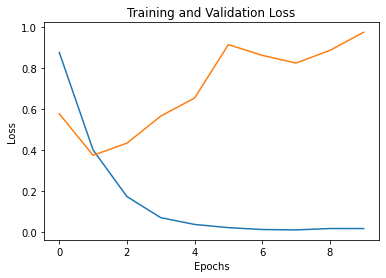

In [52]:
# Plot and label the training and validation loss values
plt.plot(list(range(0,10)), train_loss, label='Training Loss')
plt.plot(list(range(0,10)), val_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.show()

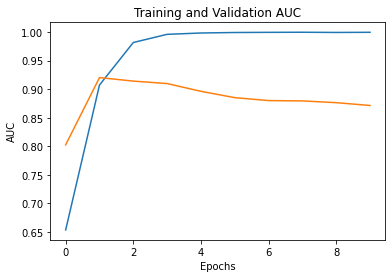

In [53]:
# Plot and label the training and validation AUC values
plt.plot(list(range(0,10)), train_auc, label='Training AUC')
plt.plot(list(range(0,10)), val_auc, label='Validation AUC')
 
# Add in a title and axes labels
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
 
# Display the plot
plt.show()

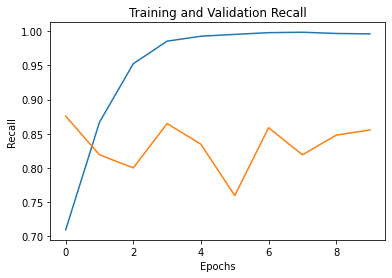

In [55]:
# Plot and label the training and validation recall values
plt.plot(list(range(0,10)), train_recall, label='Training Recall')
plt.plot(list(range(0,10)), val_recall, label='Validation Recall')
 
# Add in a title and axes labels
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')

# Display the plot
plt.show()

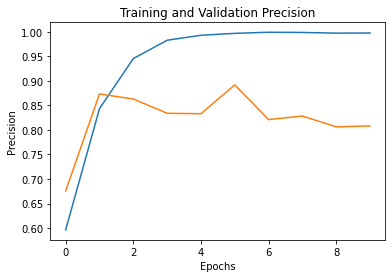

In [56]:
# Plot and label the training and validation precision values
plt.plot(list(range(0,10)), train_prec, label='Training Precision')
plt.plot(list(range(0,10)), val_prec, label='Validation Precision')
 
# Add in a title and axes labels
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')

# Display the plot
plt.show()

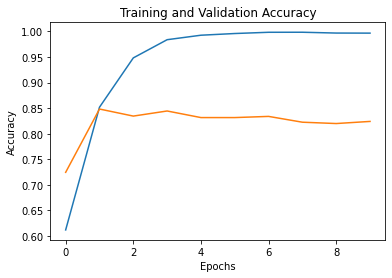

In [57]:
# Plot and label the training and validation accuracy values
plt.plot(list(range(0,10)), train_acc, label='Training Accuracy')
plt.plot(list(range(0,10)), val_acc, label='Validation Accuracy')
 
# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

In [58]:
# You will need to include the pickled model along with the other submission files
# The saved model will be used to verify your lstm's predictions on hidden reviews

##################################################################################
# Save your trained model as a pickle file named "lstm_classifier"               #
# You will be using this saved model to make predictions in the next module      #
##################################################################################

import pickle 
pickle.dump(model, open('lstm_classifier.pkl','wb'))

### Prediction (5 Points)

In [59]:
######################################################################
# Load your saved model                                              #
# Use the saved model to make predictions                            #
######################################################################

saved_model = pickle.load(open('lstm_classifier.pkl', 'rb'))

In [85]:
# use the saved model to predict the reviews
def predict_review(review):
  '''
  Arguments:
    review : A single review for which you want to predict the sentiment for.
             example: "This movie was amazing! I would defenitely watch it again."

  Returns:
    The predicted sentiment for the review : either 1 or 0
  '''

 ############################################################################# 
 # Predict the sentiment for the given review using the model                #
 # that you trained and return the sentiment                                 #
 #                                                                           #
 # HINT : Remember that the review needs to be "preprocessed" before you use #
 # it for prediction                                                         #
 #############################################################################
  review = clean_text(review);
  review_Lst = [review]
  t = Tokenizer();
  t.fit_on_texts(review_Lst)
  review_seq = t.texts_to_sequences(review_Lst)
  review_pad = pad_sequences(review_seq, padding = 'post', truncating = 'post', maxlen = 200);

  prediction = saved_model.predict(review_pad)
  y_classes=np.argmax(prediction, axis=1)

  if y_classes == 0:
    return 1;
  if y_classes == 1:
    return 0;

In [83]:
review = "If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!"

review = clean_text(review);
review_Lst = [review]
t = Tokenizer();
t.fit_on_texts(review_Lst)
review_seq = t.texts_to_sequences(review_Lst)
review_pad = pad_sequences(review_seq, padding = 'post', truncating = 'post', maxlen = 200);

prediction = saved_model.predict(review_pad)
classes_x=np.argmax(prediction, axis=1)




1/1 [==============================] - 0s 242ms/step


In [86]:
# Do not edit this cell

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = predict_review(review)
    print(f'{review[:100]} -> {p}')
    

1/1 [==============================] - 0s 71ms/step
If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1
1/1 [==============================] - 0s 56ms/step
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1
1/1 [==============================] - 0s 60ms/step
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1
1/1 [==============================] - 0s 93ms/step
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1


### Expected Output:

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0 <br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0